# Machine Scheduling

"Which job should be done next?" is a key questions one face in modern life, whether for a busy student working on course assignments, a courier delivering packages, a server waiting on tables in a busy restaurant, a computer processing threads, or machine on a complex assembly line. There are many empirical answers to this question, among them "first in, first  out", or "last  in, first out", or "shortest job first".  What we consider in this noteboked is the modeling and solution to this problem using optimiziation techniques.

This notebook demonstrates the formulation and solution of the a machine scheduling (sometimes called bottleneck) problem using disjuctive programming in Pyomo. The problem is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.

## Learning Goals

* Optimal machine scheduling
* Use of Pyomo Disjunction

## Example

The problem is to schedule a sequence of jobs for a single machine. The problem data as a nested Python dictionary of jobs. Each job is labeled by a key. For each key there is an associated data dictionary giving the time at which the job is released to the for machine processing, the expected duration of the job, and the due date. The optimization objective is to find a sequence the jobs on the machine that meets the the due dates. If no such schedule exists, then the objective is to find a schedule minimizing some measure of "badness".

In [113]:
import pandas as pd

jobs = pd.DataFrame({
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due':  5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}).T

jobs

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


In [142]:
import pyomo.environ as pyo
import pyomo.gdp as gdp

def build_model(jobs):

    m = pyo.ConcreteModel()

    m.JOBS = pyo.Set(initialize=jobs.index)

    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))
    m.past_due = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, 300))

    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.start[job] + jobs.loc[job, "duration"] == m.finish[job] 

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past_due[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Disjunction(m.JOBS, m.JOBS, xor=True)
    def machine_deconflict(m, job_a, job_b):
        if job_a < job_b:
            return [[m.finish[job_a] <= m.start[job_b]],
                    [m.finish[job_b] <= m.start[job_a]]]
        else:
            return gdp.Disjunction.Skip
    
    @m.Objective(sense=pyo.minimize)
    def minimize_past_due(m):
        return sum(m.past_due[job] for job in m.JOBS)

    pyo.TransformationFactory("gdp.bigm").apply_to(m)
    
    return m

def solve_model(m, solver_name="cbc"):
    solver = pyo.SolverFactory(solver_name)
    solver.solve(m)
    schedule = pd.DataFrame({
        "start" : {job: m.start[job]() for job in m.JOBS},
        "finish" : {job: m.finish[job]() for job in m.JOBS},
        "past_due" : {job: m.past_due[job]() for job in m.JOBS},
    })
    return schedule
    
model = build_model(jobs)
schedule = solve_model(model)

display(jobs)
display(schedule)

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


,start,finish,past_due
A,6.0,11.0,1.0
B,14.0,20.0,0.0
C,22.0,30.0,15.0
D,2.0,6.0,0.0
E,0.0,2.0,0.0
F,11.0,14.0,0.0
G,20.0,22.0,0.0


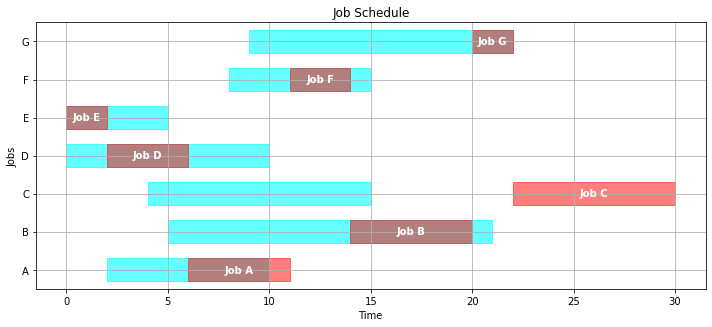

In [133]:
import matplotlib.pyplot as plt

def gantt(jobs, schedule):
    bw = 0.3
    fig, ax = plt.subplots(1, 1, figsize=(12, 0.7*len(jobs.index)))
    for k, job in enumerate(jobs.index):
        x = jobs.loc[job, "release"]
        y = jobs.loc[job, "due"]
        ax.fill_between([x, y], [k-bw, k-bw], [k+bw, k+bw], color="cyan", alpha=0.6)
        
    for k, job in enumerate(schedule.index):
        x = schedule.loc[job, "start"]
        y = schedule.loc[job, "finish"]
        ax.fill_between([x, y], [k-bw, k-bw], [k+bw, k+bw], color="red", alpha=0.5)
        
        ax.text((schedule.loc[job, "start"] + schedule.loc[job, "finish"])/2.0, k, 
                 "Job " + job, color="white", weight="bold",
                 ha="center", va="center")
        
    ax.set_ylim(-0.5, len(jobs.index)-0.5)
    ax.set_title('Job Schedule')
    ax.set_xlabel('Time')
    ax.set_ylabel('Jobs')
    ax.set_yticks(range(len(jobs.index)), jobs.index)
    ax.grid(True)
        
gantt(jobs, schedule)